In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load data
data = pd.read_csv('final_dataset.csv')
data_column = data.iloc[:, 0].values

# Normalize the data
scaler = StandardScaler()
data_column_normalized = scaler.fit_transform(data_column.reshape(-1, 1)).flatten()

In [3]:
# Convert data to tensor and reshape
data_tensor = torch.tensor(data_column_normalized, dtype=torch.float32)
X = data_tensor.reshape((168280, 100))
X = X.unsqueeze(1)

# Load labels
labels = pd.read_csv('label.csv').values
y = labels.squeeze(1).tolist()

# Generate error tensor
error = torch.tensor(list(map(lambda x: [x]*6010, y)))
Y = error.flatten()
Y.shape


torch.Size([168280])

In [4]:
# Train-test split
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, Y-1, test_size=0.3, random_state=42, stratify=Y-1)
X_train , X_valid , Y_train , Y_valid = train_test_split (X_train_valid , Y_train_valid , test_size= 0.25 , random_state=42 , stratify=Y_train_valid)



In [5]:
# Create DataLoader
batch_size = 100
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid,Y_valid)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)
        
    def forward(self, x):
        _, hidden = self.gru(x)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:

# Parameters
input_size = 100       # Assuming one feature per time step
hidden_size = 64   # Number of hidden units in the RNN
output_size = 4        # Number of classes for classification
num_layers = 2         # Number of RNN layers
learning_rate = 0.001



In [16]:
model = RNN(input_size, hidden_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def train_and_evaluate(model, num_epochs, train_loader, valid_loader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct_train = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct_train.sum()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct_valid = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct_valid.sum()

        loss_hist_valid[epoch] /= len(valid_loader.dataset)
        accuracy_hist_valid[epoch] /= len(valid_loader.dataset)

        # if (epoch + 1) % 20 == 0:
        print(f'Epoch[{epoch+1}]: T_Acc: {accuracy_hist_train[epoch]:.3f}   V_Acc: {accuracy_hist_valid[epoch]:.3f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [18]:
torch.manual_seed(1)
num_epochs = 50
result = train_and_evaluate(model, num_epochs, train_loader, valid_loader)



Epoch[1]: T_Acc: 0.559   V_Acc: 0.712
Epoch[2]: T_Acc: 0.730   V_Acc: 0.752
Epoch[3]: T_Acc: 0.770   V_Acc: 0.787
Epoch[4]: T_Acc: 0.796   V_Acc: 0.818
Epoch[5]: T_Acc: 0.829   V_Acc: 0.832
Epoch[6]: T_Acc: 0.844   V_Acc: 0.828
Epoch[7]: T_Acc: 0.859   V_Acc: 0.850
Epoch[8]: T_Acc: 0.868   V_Acc: 0.866
Epoch[9]: T_Acc: 0.873   V_Acc: 0.868
Epoch[10]: T_Acc: 0.882   V_Acc: 0.870
Epoch[11]: T_Acc: 0.885   V_Acc: 0.880
Epoch[12]: T_Acc: 0.891   V_Acc: 0.885
Epoch[13]: T_Acc: 0.894   V_Acc: 0.880
Epoch[14]: T_Acc: 0.898   V_Acc: 0.890
Epoch[15]: T_Acc: 0.899   V_Acc: 0.885
Epoch[16]: T_Acc: 0.902   V_Acc: 0.890
Epoch[17]: T_Acc: 0.905   V_Acc: 0.891
Epoch[18]: T_Acc: 0.906   V_Acc: 0.892
Epoch[19]: T_Acc: 0.908   V_Acc: 0.897
Epoch[20]: T_Acc: 0.911   V_Acc: 0.889
Epoch[21]: T_Acc: 0.913   V_Acc: 0.884
Epoch[22]: T_Acc: 0.915   V_Acc: 0.889
Epoch[23]: T_Acc: 0.916   V_Acc: 0.893
Epoch[24]: T_Acc: 0.917   V_Acc: 0.895
Epoch[25]: T_Acc: 0.918   V_Acc: 0.897
Epoch[26]: T_Acc: 0.920   V_Acc: 0

C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_16828\1430446203.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
C:\Users\Albaloo Rayaneh\AppData\Local\Temp\ipykernel_16828\1430446203.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]


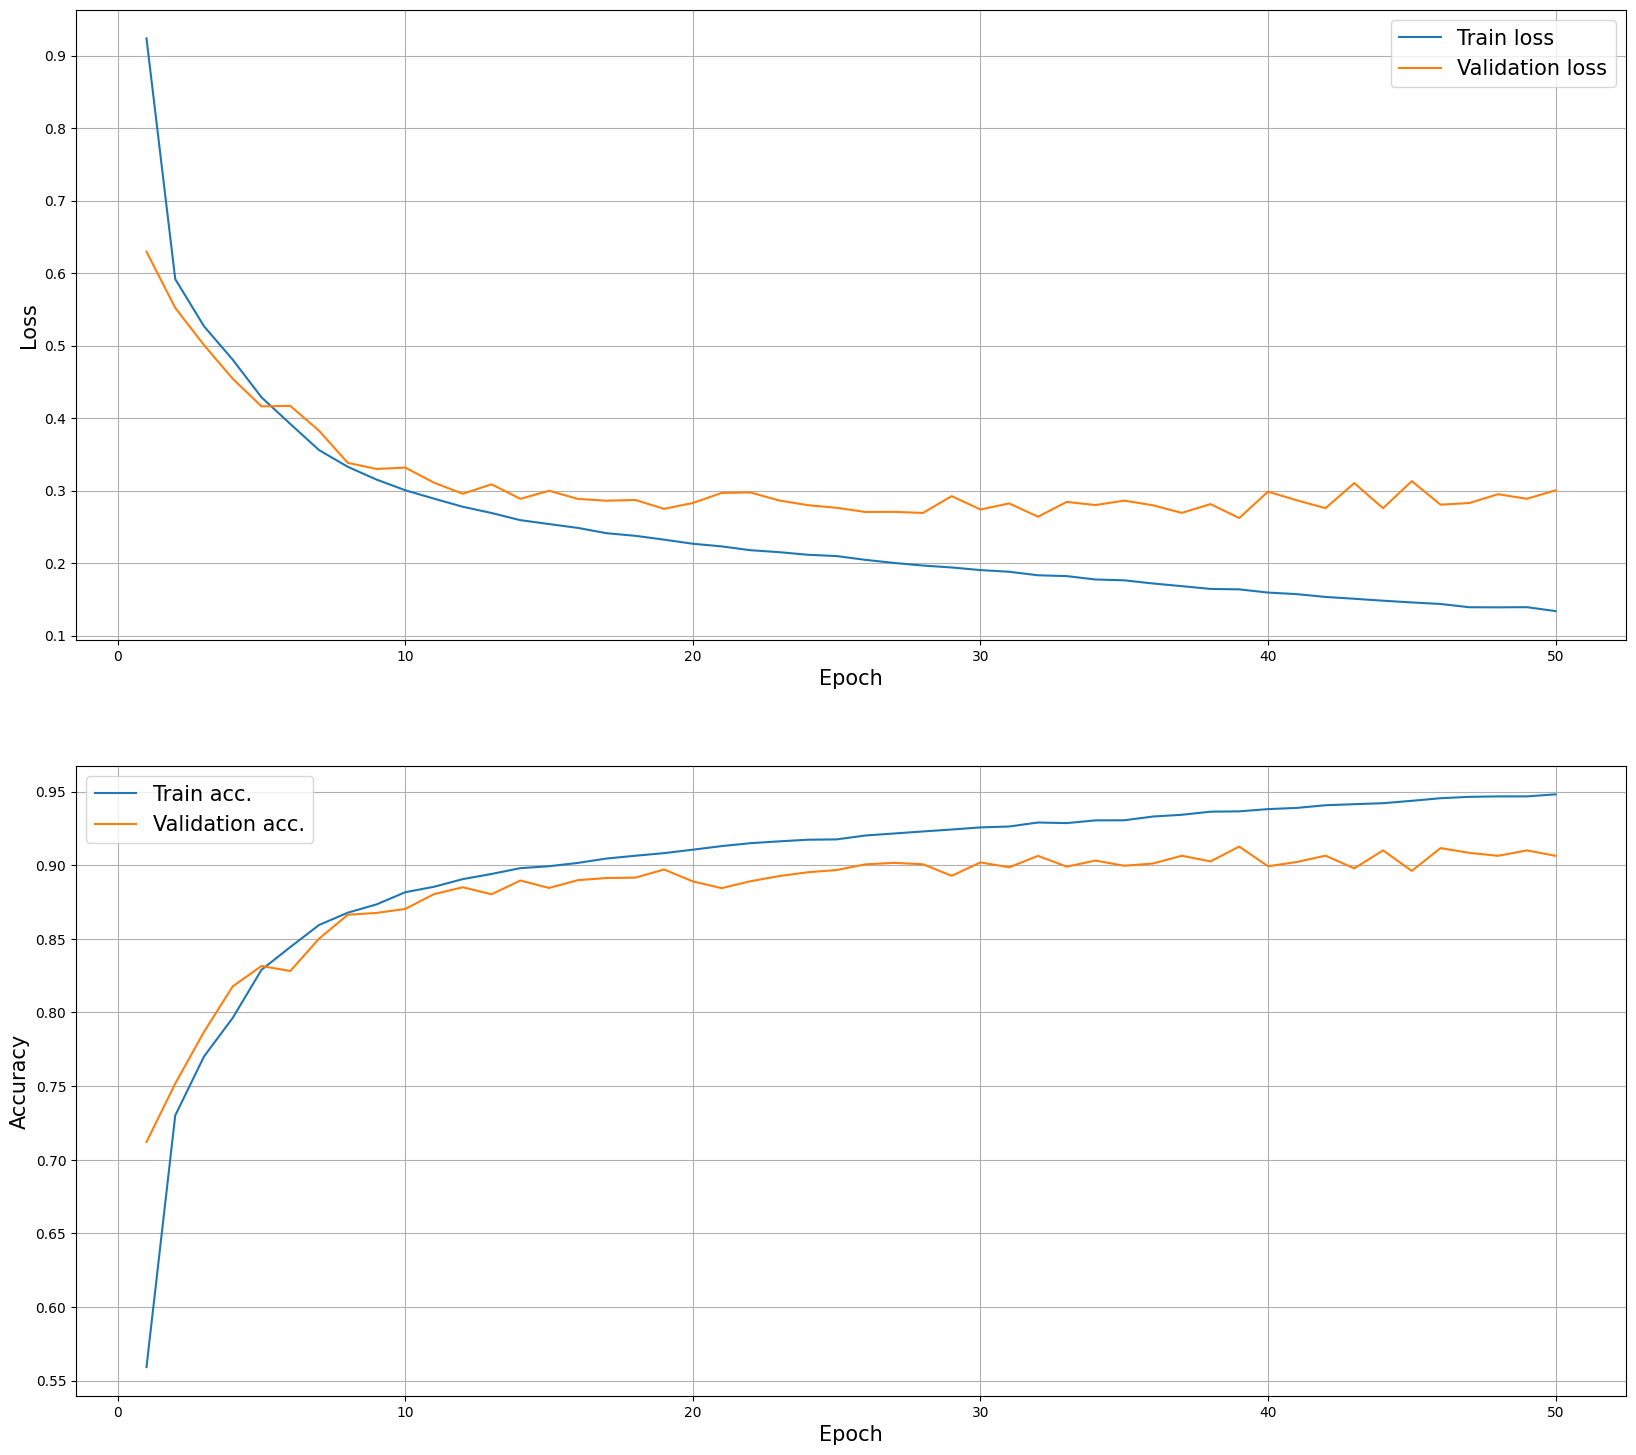

In [23]:
x_arr = np.arange(len(result[0])) + 1

train_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[0]]
valid_loss_cpu = [torch.tensor(x).cpu().numpy() for x in result[1]]
train_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[2]]
valid_acc_cpu = [torch.tensor(x).cpu().numpy() for x in result[3]]

fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(2, 1, 1)
ax.plot(x_arr, train_loss_cpu, label='Train loss')
ax.plot(x_arr, valid_loss_cpu, label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.grid(True)
ax.legend(fontsize=15)

ax = fig.add_subplot(2, 1, 2)
ax.plot(x_arr, train_acc_cpu, label='Train acc.')
ax.plot(x_arr, valid_acc_cpu, label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.grid(True)
plt.show()


In [24]:

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            test_loss += loss_fn(pred, y_batch).item() * y_batch.size(0)
            correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {accuracy:.3f}')

test_model(model, test_loader)    

Test Loss: 0.308, Test Accuracy: 0.906


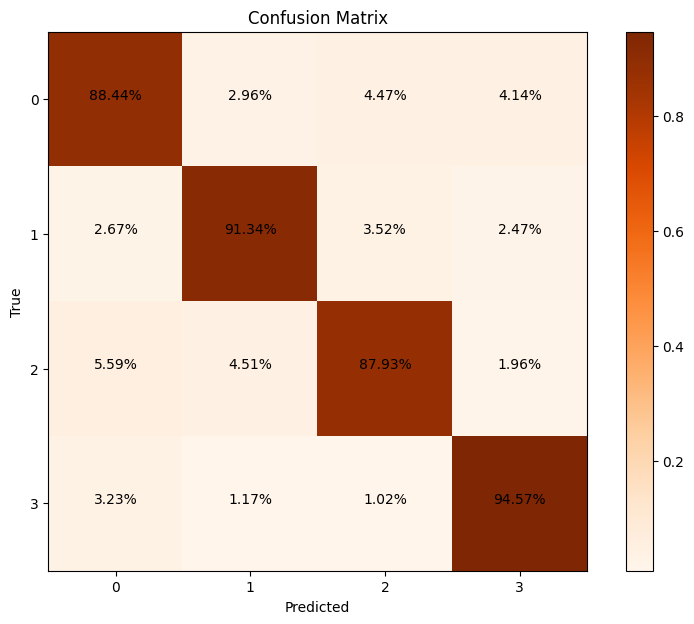

In [25]:

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm_normalized, interpolation='nearest', cmap='Oranges')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(all_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, f'{cm_normalized[i, j]:.2%}', horizontalalignment='center', color='black')

    plt.show()

plot_confusion_matrix(model, test_loader)


In [26]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            all_preds.extend(torch.argmax(pred, dim=1).cpu().numpy()) 
            all_labels.extend(y_batch.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))


evaluate_model(model, test_loader)


Classification Report:
              precision    recall  f1-score   support

           0     0.8850    0.8844    0.8847     12621
           1     0.9136    0.9134    0.9135     12621
           2     0.9071    0.8793    0.8930     12621
           3     0.9169    0.9457    0.9311     12621

    accuracy                         0.9057     50484
   macro avg     0.9056    0.9057    0.9056     50484
weighted avg     0.9056    0.9057    0.9056     50484

